**1) PRE-PROCESSING**

---


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 8

# Feature extraction Libs
import requests
from urllib.parse import urlparse, urlsplit
import tldextract

In [2]:
data = pd.read_csv('datasets/malicious_urls.csv')
data.describe()

,url,type
count,663191,663191
unique,653040,5
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [3]:
# Removing duplicates
data = data.drop_duplicates(subset='url')
data.describe()

,url,type
count,653040,653040
unique,653040,5
top,br-icloud.com.br,benign
freq,1,428080


In [4]:
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
663186,http://archive.salisburyjournal.co.uk/2001/3/7/,spam
663187,http://astore.amazon.co.uk/allezvinsfrenchr/de...,spam
663188,http://archive.thisischeshire.co.uk/2000/1/14/...,spam
663189,http://applerugs.co.uk/rugs/product_info.php?p...,spam


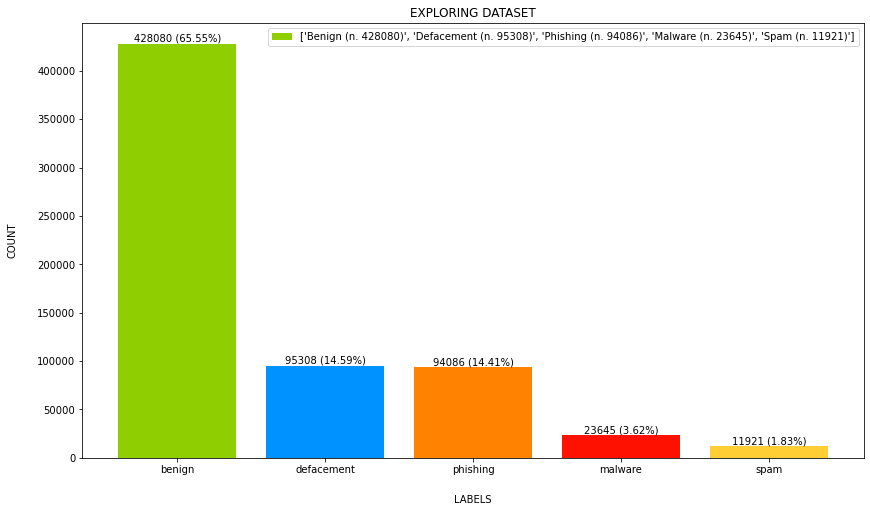

In [7]:
count = data.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

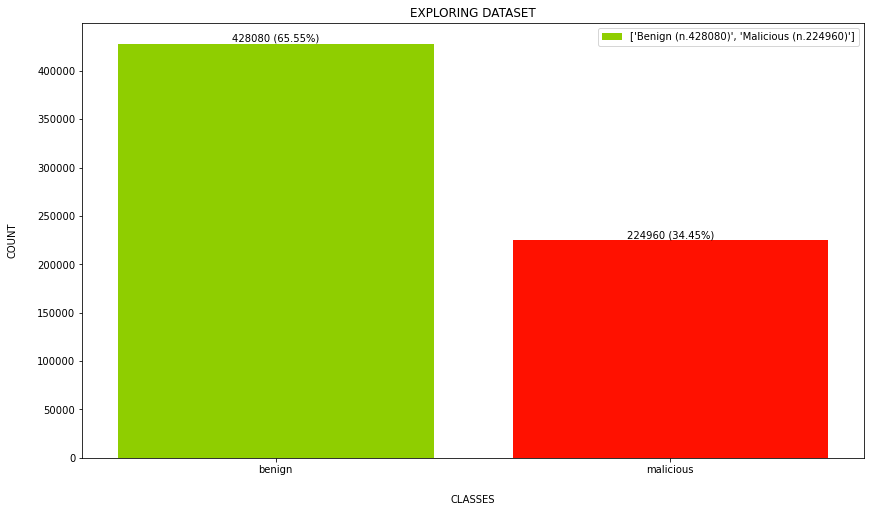

In [8]:
benign = count[0]
malicious = len(data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

In [9]:
benign_urls = data[data['type'] == 'benign']
defacement_urls = data[data['type'] == 'defacement']
phishing_urls = data[data['type'] == 'phishing']
malware_urls = data[data['type'] == 'malware']
spam_urls = data[data['type'] == 'spam']

benign_urls_sample = random.sample(list(benign_urls.index), 10000)
defacement_urls_sample = random.sample(list(defacement_urls.index), 2500)
phishing_urls_sample = random.sample(list(phishing_urls.index), 2500)
malware_urls_sample = random.sample(list(malware_urls.index), 2500)
spam_urls_sample = random.sample(list(spam_urls.index), 2500)

selected_indexes = benign_urls_sample + defacement_urls_sample + phishing_urls_sample + malware_urls_sample + spam_urls_sample
random.shuffle(selected_indexes)
data_sampled = data.loc[selected_indexes]
data_sampled = data_sampled.reset_index(drop=True)

In [10]:
data_sampled.describe()

,url,type
count,20000,20000
unique,20000,5
top,nsb.com/speakers/view/alexandre-despatie,benign
freq,1,10000


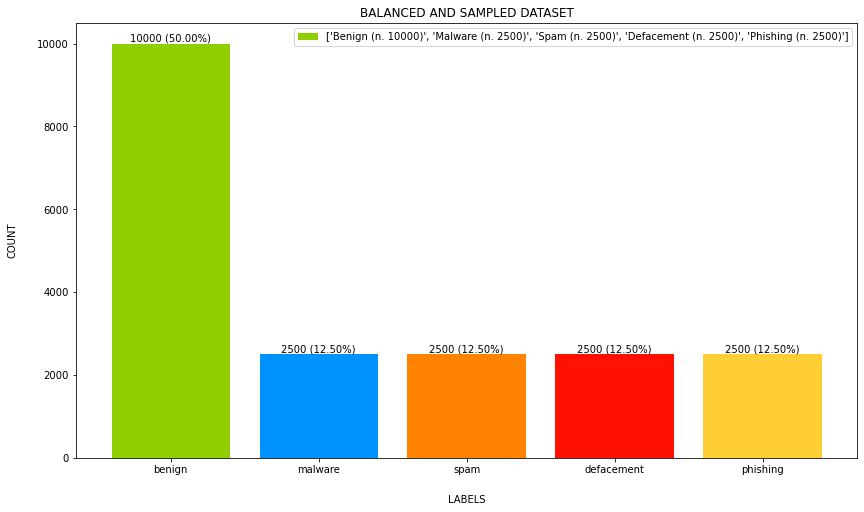

In [11]:
count = data_sampled.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data_sampled)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('BALANCED AND SAMPLED DATASET')
plt.legend()
plt.show()

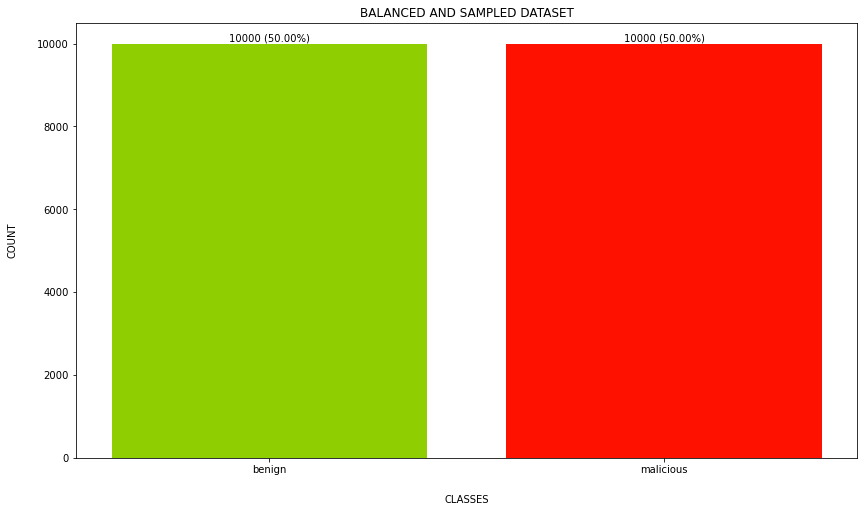

In [12]:
benign = count[0]
malicious = len(data_sampled) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data_sampled)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('BALANCED AND SAMPLED DATASET')
plt.show()

In [11]:
# file_path = 'datasets/urls_sampled.csv'
# data_sampled.to_csv(file_path, index=False)
# data = pd.read_csv(file_path)
# data.describe()

,url,type
count,20000,20000
unique,20000,5
top,http://173.15.162.156:4755/Mozi.m,benign
freq,1,10000


**2) FEATURES ENGINEERING**

---


In [13]:
#
# Number of character '.' in URL
# Return: numeric
#
def count_dots(url: str):
    return url.count('.')


#
# Number of subdomain levels
# Return: numeric
#
def count_subdomains(url: str):
    subdomain = tldextract.extract(url).subdomain
    return len(subdomain.split('.')) if len(subdomain) != 0 else 0


#
# The depth of URL
# Return: numeric
#
def get_path_level(url: str):
    path = urlsplit(url).path
    path = path[1:] if len(path) > 0 and path[0] == '/' else path
    path = path[:-1] if len(path) > 0 and path[-1] == '/' else path
    return len(path.split('/')) if len(path) > 0 else 0


#
# The length of URL
# Return: numeric
#
def get_len(url: str):
    return len(url)


#
# Number of the dash character '-' in URL
# Return: numeric
#
def count_dash(url: str):
    return url.count('-')


#
# There exists a character '@' in URL
# Return: boolean
#
def check_at_symbol(url: str):
    return '@' in url


#
# There exists a character '~' in URL
# Return: boolean
#
def check_tilde_symbol(url: str):
    return '~' in url


#
# Number of the underscore character '_' in URL
# Return: numeric
#
def count_underscore(url: str):
    return url.count('_')


#
# Number of the percent character '%' in URL
# Return: numeric
#
def count_percent(url: str):
    return url.count('%')


#
# Number of the query components
# Return: numeric
#
def count_query_components(url: str):
    query_components = urlparse(url).query.split("&") if len(urlparse(url).query) > 0 else ''
    return len(query_components)


#
# Number of the ampersand character '&' in URL
# Return: numeric
#
def count_ampersand(url: str):
    return url.count('&')


#
# Number of the hash character '#' in URL
# Return: numeric
#
def count_hash(url: str):
    return url.count('#')


#
# Number of the numeric character
# Return: numeric
#
def count_digits(url: str):
    return sum(c.isdigit() for c in url)


#
# Check if there exists a HTTPS in website URL
# Return: boolean
#
def check_Https(url: str):
    try:
        req = requests.get(url, timeout=1).url
        return req.startswith('https')
    except Exception as e:
        return False


#
# Check if the IP address is used in the hostname of the website URL
# Return: boolean
#
def check_IP_address(url: str):
    return not bool(sum(not c.isdigit() and c != '.' for c in tldextract.extract(url).domain))


#
# Check if TLD is used as a part of the subdomain in website URL
# Return: boolean
#
def check_tld_in_subdomain(url: str):
    res = tldextract.extract(url)
    return res.domain in res.subdomain


#
# Check if TLD is used in the link of website URL
# Return: boolean
#
def check_tld_in_path(url: str):
    return tldextract.extract(url).domain in urlsplit(url).path


#
# Check if HTTPS is disordered in the hostname of website URL
# Return: boolean
#
def check_https_in_hostname(url: str):
    return 'https' in urlsplit(url).netloc


#
# Length of hostname
# Return: numeric
#
def get_hostname_length(url: str):
    return len(urlsplit(url).netloc)


#
# Length of the link path
# Return: numeric
#
def get_path_length(url: str):
    return len(urlparse(url).path)


#
# Length of the query string
# Return: numeric
#
def get_query_length(url):
    return len(urlparse(url).query)


#
# There exists a slash '//' in the link path
# Return: boolean
#
def check_double_slash_in_path(url: str):
    return '//' in urlparse(url).path


#
# Compute the lexical features by URL
# Return: Pandas.Series
#
def get_lexical_features(url, label):
    if not url.startswith(('http://', 'https://', 'ftp://')):
        url = 'http://' + url
    return [
        url,
        count_dots(url),
        count_subdomains(url),
        get_path_level(url),
        get_len(url),
        count_dash(url),
        check_at_symbol(url),
        check_tilde_symbol(url),
        count_underscore(url),
        count_percent(url),
        count_query_components(url),
        count_ampersand(url),
        count_hash(url),
        count_digits(url),
        check_Https(url),
        check_IP_address(url),
        check_tld_in_subdomain(url),
        check_tld_in_path(url),
        check_https_in_hostname(url),
        get_hostname_length(url),
        get_path_length(url),
        get_query_length(url),
        check_double_slash_in_path(url),
        label
    ]

In [14]:
data_features = pd.DataFrame({
    'url':[],
    'numDots':[],
    'subdomainLevel':[],
    'pathLevel':[],
    'urlLength':[],
    'numDash':[], 
    'atSymbol':[],
    'tildeSymbol':[],
    'numUnderscore':[],
    'numPercent':[],
    'numQueryComponents':[],
    'numApersand':[],          
    'numHash':[],
    'numDigits':[],
    'https':[],
    'ipAddress':[], 
    'domainInSubdomains':[],
    'domainInPaths':[],
    'httpsInHostname':[],
    'hostnameLength':[],
    'pathLength':[],
    'queryLength':[],
    'doubleSlash':[],
    'type': []
})

In [18]:
# for i in range(len(data)):
#     url = data.loc[i, 'url']
#     label = data.loc[i, 'type']
#     if (i % 500 == 0):
#         print('Rows processed: ',i)
#     try:
#         data_features.loc[i] = get_lexical_features(url, label)
#     except Exception as e:
#         print('>>>>>>> EXCEPTION: ',e)
#         print('>>>>>>> EXCEPTION URL: ',url)
#         print('>>>>>>> EXCEPTION INDEX: ',i)
#         continue
# data_features.to_csv('/content/urls_with_features.csv', index = False)

**2) EXPLORATIVE DATA ANALYSIS**

---


In [3]:
data = pd.read_csv('datasets/urls_with_features.csv')
data.describe()

,numDots,subdomainLevel,pathLevel,urlLength,numDash,numUnderscore,numPercent,numQueryComponents,numApersand,numHash,numDigits,hostnameLength,pathLength,queryLength
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.482300,0.491650,2.169350,70.553750,1.289450,0.48425,0.365150,0.668000,0.45590,0.000650,7.918400,17.517150,27.930800,17.603400
std,1.498532,0.908775,1.548383,71.897412,2.689336,1.51399,3.837832,1.563745,1.32153,0.029148,15.195482,10.205705,26.701628,67.855277
min,0.000000,0.000000,0.000000,13.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,38.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,12.000000,10.000000,0.000000
50%,2.000000,0.000000,2.000000,53.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,4.000000,16.000000,21.000000,0.000000
75%,3.000000,1.000000,3.000000,83.000000,1.000000,0.00000,0.000000,0.000000,0.00000,0.000000,10.000000,20.000000,37.000000,0.000000
max,25.000000,18.000000,18.000000,1424.000000,39.000000,20.00000,147.000000,28.000000,27.00000,2.000000,332.000000,244.000000,755.000000,1388.000000


In [4]:
# Null values check
data.isnull().any()

url                   False
numDots               False
subdomainLevel        False
pathLevel             False
urlLength             False
numDash               False
atSymbol              False
tildeSymbol           False
numUnderscore         False
numPercent            False
numQueryComponents    False
numApersand           False
numHash               False
numDigits             False
https                 False
ipAddress             False
domainInSubdomains    False
domainInPaths         False
httpsInHostname       False
hostnameLength        False
pathLength            False
queryLength           False
doubleSlash           False
type                  False
dtype: bool

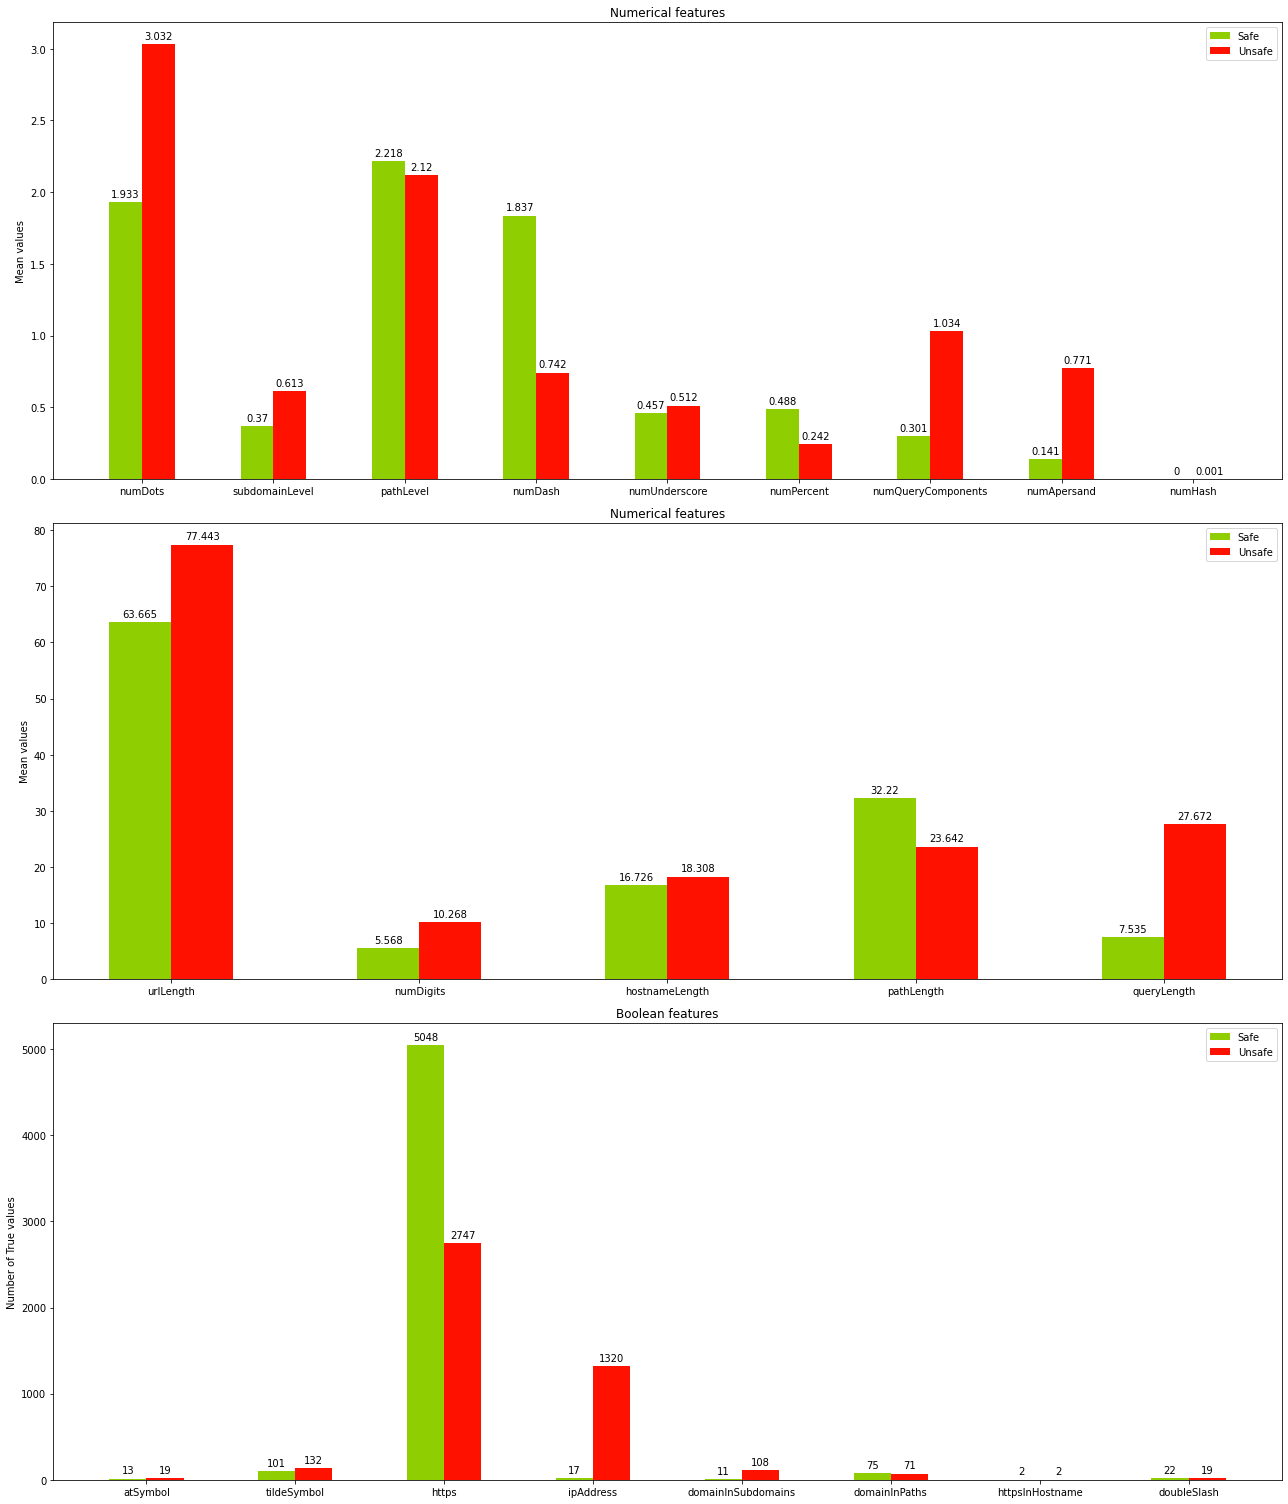

In [6]:
safe = data[data['type'] == 'benign']
unsafe = data[data['type'] != 'benign']

# Numerical features
labels_x1 = ['numDots', 'subdomainLevel', 'pathLevel', 'numDash', 'numUnderscore', 'numPercent', 'numQueryComponents', 'numApersand', 'numHash']
labels_x2 = ['urlLength', 'numDigits', 'hostnameLength', 'pathLength', 'queryLength']
# Boolean features
labels_x3 = ['atSymbol', 'tildeSymbol', 'https', 'ipAddress', 'domainInSubdomains', 'domainInPaths', 'httpsInHostname', 'doubleSlash']

features_to_plot1 = {'Safe': [], 'Unsafe': []}
features_to_plot2 = {'Safe': [], 'Unsafe': []}
features_to_plot3 = {'Safe': [], 'Unsafe': []}

for i in labels_x1:
    features_to_plot1['Safe'].append(safe.loc[:, i].mean())
    features_to_plot1['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x2:
    features_to_plot2['Safe'].append(safe.loc[:, i].mean())
    features_to_plot2['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x3:
    features_to_plot3['Safe'].append(safe.loc[:, i].sum())
    features_to_plot3['Unsafe'].append(unsafe.loc[:, i].sum())

x1 = np.arange(len(labels_x1))  # the label locations
x2 = np.arange(len(labels_x2))  # the label locations
x3 = np.arange(len(labels_x3))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(18, 21))

for attribute, measurement in features_to_plot1.items():
    offset = width * multiplier
    rects = ax1.bar(x1 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax1.bar_label(rects, padding = 3)
    multiplier += 1
ax1.set_ylabel('Mean values')
ax1.set_title('Numerical features')
ax1.set_xticks(x1 + (width / 2), labels_x1)
ax1.legend(loc = 'upper right')

for attribute, measurement in features_to_plot2.items():
    offset = width * multiplier
    rects = ax2.bar(x2 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax2.bar_label(rects, padding = 3)
    multiplier += 1
ax2.set_ylabel('Mean values')
ax2.set_title('Numerical features')
ax2.set_xticks(x2 + (width*2.5), labels_x2)
ax2.legend(loc = 'upper right')

for attribute, measurement in features_to_plot3.items():
    offset = width * multiplier
    rects = ax3.bar(x3 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax3.bar_label(rects, padding = 3)
    multiplier += 1
ax3.set_ylabel('Number of True values')
ax3.set_title('Boolean features')
ax3.set_xticks(x3 + (width*4.5), labels_x3)
ax3.legend(loc = 'upper right')

plt.tight_layout()
plt.show()